# Adversarial Julia Demo
## Load the modules

In [44]:
import Missings
using CSV
using Knet
using Plots
using Images, Colors
using Statistics
using StatsBase
include("Adversarial.jl")

Main.adv

## Load the data

In [32]:
include(Knet.dir("data","mnist.jl"))
xsize=784
ysize=10
train, test = mnistdata(xsize=(xsize,:))

(Data(Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], UInt8[0x05 0x0a … 0x06 0x08], 100, 60000, false, 1:60000, false, (784, Colon()), (60000,), Array{Float32,N} where N, Array{UInt8,1}), Data(Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], UInt8[0x07 0x02 … 0x05 0x06], 100, 10000, false, 1:10000, false, (784, Colon()), (10000,), Array{Float32,N} where N, Array{UInt8,1}))

## Initialize and train an MLP

In [33]:
vals = (784, 64, 10)
model = adv.MLP(vals...)
@show adv.accuracy(model, test)
@time adv.trainresults(model, train; pdrop=(0.2, 0.0))
accuracy(model, test)

adv.accuracy(model, test) = 0.1427
 38.570436 seconds (10.93 M allocations: 28.193 GiB, 6.87% gc time)


0.978

## Load the test set

In [34]:
examples = []
for (x,y) in test
    push!(examples, (x,y))
end

## Run an adversarial attack against the trained model on the test set

In [48]:
# Choose a distance metric (recommended adv.L2_dist and adv.DSSIM)
dist = adv.L2_dist
# Initialize an attack algorithm with the desired parameters
# Attacks include:
# adv.adv_fast_gradient_sign
# adv.adv_iterative_gradient_sign
# adv.adv_LBFGS
# adv.adv_fast_LBFGS
# adv.JSMA
# adv.adv_carlini_wagner
# See function documentation in Adversarial.jl for more details on each function
g(x0, model, target) = adv.adv_fast_gradient_sign(x0, model, target; ϵ=.1)

example = examples[1]
x0 = example[1][:, 1]
y0 = example[2][1]
println("The sample is a $y0")
target = 3

x1 = g(x0, model, target)

pred = adv.predict_class(model, x1)
dist = dist(x1, x0)
println("The model classifies it as a $pred with a distance of $dist from the original")

The sample is a 7
The model classifies it as a 3 with a distance of 7.840000000000003 from the original


## Display the original and adversarial images

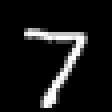

In [49]:
L = Int(√(length(x1)))
img1 = reshape(x0, (L,L))'
Gray.(img1)

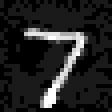

In [50]:
img2 = reshape(x1, (L, L))'
Gray.(img2)

## Run large scale tests and plot the success rates

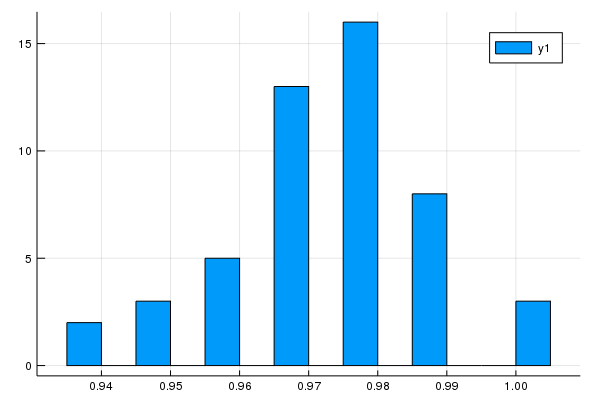

In [30]:
# This will run very slowly for adv.adv_LBFGS
g(x0, model, target) = adv.adv_iterative_gradient_sign(x0, model, target; ϵ=15)
success_rates = []
for i in 1:50
    append!(success_rates, adv.targetted_test(model, examples; alg=g))
end
histogram(success_rates, fmt=:png)